# Convolutional Neural Networks (CNN)
<font color='blue'>
<br>Content: 
    
* [Loading the Data Set](#1)
* [Normalization, Reshape and Label Encoding ](#2)
* [Train Test Split](#3)
* [Convolutional Neural Network](#4)
    * [What is Convolution Operation?](#5)
    * [Same Padding](#6)
    * [Max Pooling](#7)
    * [Flattening](#8)
    * [Full Connection](#9)
* [Implementing with Keras](#10)
    * [Create Model](#11)
    * [Define Optimizer](#12)
    * [Compile Model](#13)
    * [Epochs and Batch Size](#14)
    * [Data Augmentation](#15)
    * [Fit the Model](#16)
    * [Evaluate the Model](#17)



<a id="1"></a>
## Installing the dependencies

In [116]:
!pip install pillow

In [117]:
!pip install keras
!pip install tensorflow
!pip install scikit-learn
!pip install imutils
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [118]:
# Keras imports
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from keras.utils import img_to_array, load_img
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image


# # sklearn imports
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# # imutils imports
from imutils import paths

# # misc
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import os
import cv2

from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [119]:
folder_path = os.path.join(os.getcwd(), "datasets/FMD-SD")

for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss0.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss1.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss10.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss100.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss101.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss102.xml
c:\Users\User\Desktop\3BSCS2\cs180\CS180-MaskPatrol-Eye-Spy-the-Masked\datasets/FMD-SD\Face Mask Detection\annotations\maksssksksss103.xml
c:\Users\User\Desktop\3BSCS2\cs1

# Haarcascade to detect faces

Constructing the Face Model

In [120]:
# getting the haarcascade_path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
haarcascade_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Haarcascades', 'haarcascade_frontalface_default.xml')  # Specify the relative path to the image file

# constructing the face_model
face_model = cv2.CascadeClassifier(haarcascade_path)

Testing the Face Model

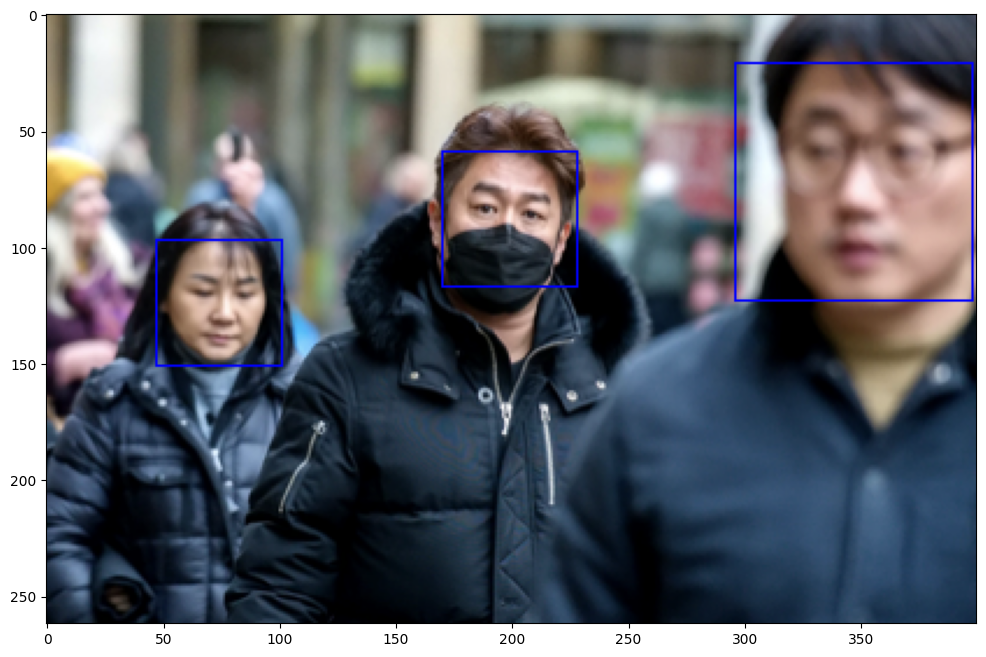

In [121]:
# getting the test image path
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
image_path = os.path.join(base_dir, 'datasets', 'FMD-SD', 'Face Mask Detection', 'images', 'maksssksksss244.png') # Specify the relative path to the image file

# reading and preprocessing the image
img = cv2.imread(image_path) # Read the image using cv2.imread()
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE) # coloring the image

# detecting the faces in the image using face_model
faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting the rectangles on the faces from the face_model
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

# show the plot
plt.figure(figsize=(12,12))
plt.imshow(out_img)

Testing Social Distancing Violations

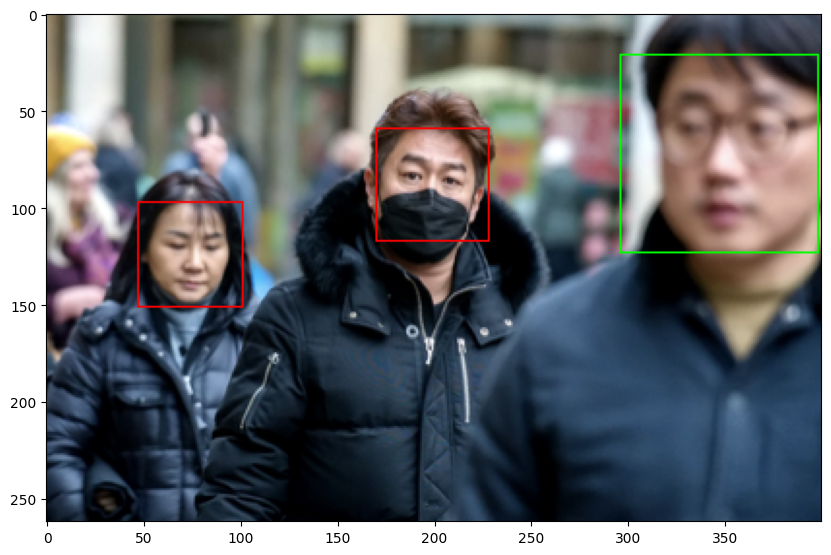

In [122]:
MIN_DISTANCE = 130

if len(faces)>=2:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")

# Face Mask Detector

Load the images into image arrays

In [123]:
# load the images into image arrays
data = []
labels = []

# getting the path of the cmfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'CMFD', '00000') # Specify the relative path to the cmfd folder

# loading the cmfd images into data and labels
for img in os.listdir(dir_path):
    img_path = os.path.join(dir_path,img)
    # print(img_path)
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(0)

In [125]:
# getting the path of the imfd (only the first 1000 images)
base_dir = os.path.dirname(os.path.abspath('__file__')) # Get the parent directory of the notebook
dir_path = os.path.join(base_dir, 'datasets', 'MaskedFace-Net', 'IMFD', '00000') # Specify the relative path to the imfd folder

# loading the cmfd images into data and labels
label = ""
for img in os.listdir(dir_path):
    # assigning the label
    if "Nose" not in img and "Mouth" not in img:
        label=1
    elif "Chin" not in img:
        label=2
    elif "Nose" not in img:
        label=3

    img_path = os.path.join(dir_path,img)
    # print(img, label)
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

Perform one-hot encoding on the labels

In [126]:
# lb = LabelBinarizer()
labels = to_categorical(labels)
print(labels)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [127]:
data=np.array(data, dtype="float32")
labels=np.array(labels)

In [128]:
print(data)
print(labels)

[[[[-0.9764706   0.04313731  0.1686275 ]
   [-1.         -0.00392157  0.12941182]
   [-1.          0.01176476  0.13725495]
   ...
   [-0.99215686 -0.06666666  0.21568632]
   [-1.         -0.09803921  0.19215691]
   [-1.         -0.09019607  0.18431377]]

  [[-0.99215686  0.02745104  0.15294123]
   [-1.         -0.00392157  0.12941182]
   [-1.          0.01176476  0.12156868]
   ...
   [-1.         -0.11372548  0.17647064]
   [-1.         -0.11372548  0.17647064]
   [-1.         -0.10588235  0.17647064]]

  [[-1.          0.0196079   0.14509809]
   [-0.9843137   0.01176476  0.12941182]
   [-1.         -0.00392157  0.09803927]
   ...
   [-1.         -0.12156862  0.1686275 ]
   [-1.         -0.10588235  0.18431377]
   [-0.99215686 -0.11372548  0.18431377]]

  ...

  [[-0.8352941   0.19215691  0.33333337]
   [-0.8117647   0.21568632  0.35686278]
   [-0.84313726  0.20000005  0.33333337]
   ...
   [-0.00392157  0.21568632  0.22352946]
   [ 0.02745104  0.22352946  0.254902  ]
   [ 0.02745104 

<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [129]:
data.shape

(2806, 224, 224, 3)

In [130]:
# Split the train and the validation set for the fitting
# Reshape the data and labels if necessary
# data = np.reshape(data, (data.shape[0], -1))
# labels = np.reshape(labels, (labels.shape[0], -1))

# Split the data and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Check the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2244, 224, 224, 3)
X_test shape: (562, 224, 224, 3)
y_train shape: (2244, 4)
y_test shape: (562, 4)


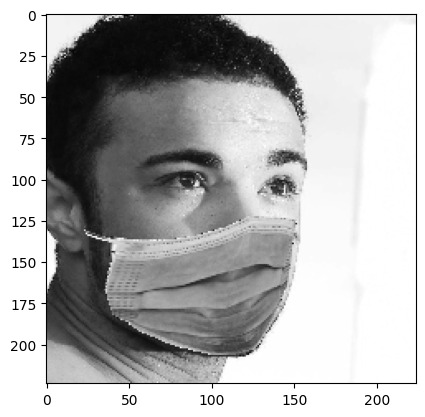

In [132]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 

In [140]:
# instantiate values
lr = 1e-4 
epoch = 20
bs = 32 

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224,224,3))
)

# constructing the head model
head_model = base_model.output  #aligns head model to the output of the base model
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(4, activation="softmax")(head_model)

In [141]:
#place the head FC model on top of the base model

model = Model(inputs=base_model.input, outputs=head_model)

In [142]:
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [143]:
#compile the model
opt = Adam(lr=lr, decay=lr/epoch)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [144]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [145]:
epoch = 10

history = model.fit_generator(
    aug.flow(X_train,y_train, batch_size=bs),
    epochs = epoch, 
    validation_data = (X_test,y_test), 
    validation_steps=len(X_test) // bs,
    steps_per_epoch=len(X_train) // bs
    )

Epoch 1/10
70/70 [==============================] - 41s 564ms/step - loss: 1.0227 - accuracy: 0.6302 - val_loss: 0.5754 - val_accuracy: 0.8167
Epoch 2/10
70/70 [==============================] - 39s 552ms/step - loss: 0.6275 - accuracy: 0.7880 - val_loss: 0.4461 - val_accuracy: 0.8505
Epoch 3/10
70/70 [==============================] - 39s 552ms/step - loss: 0.5001 - accuracy: 0.8214 - val_loss: 0.3726 - val_accuracy: 0.8701
Epoch 4/10
70/70 [==============================] - 39s 561ms/step - loss: 0.4436 - accuracy: 0.8382 - val_loss: 0.3197 - val_accuracy: 0.8826
Epoch 5/10
70/70 [==============================] - 40s 572ms/step - loss: 0.3600 - accuracy: 0.8626 - val_loss: 0.2822 - val_accuracy: 0.9039
Epoch 6/10
70/70 [==============================] - 41s 578ms/step - loss: 0.3236 - accuracy: 0.8874 - val_loss: 0.2564 - val_accuracy: 0.9164
Epoch 7/10
70/70 [==============================] - 42s 598ms/step - loss: 0.3139 - accuracy: 0.8870 - val_loss: 0.2282 - val_accuracy: 0.9235

Predicting

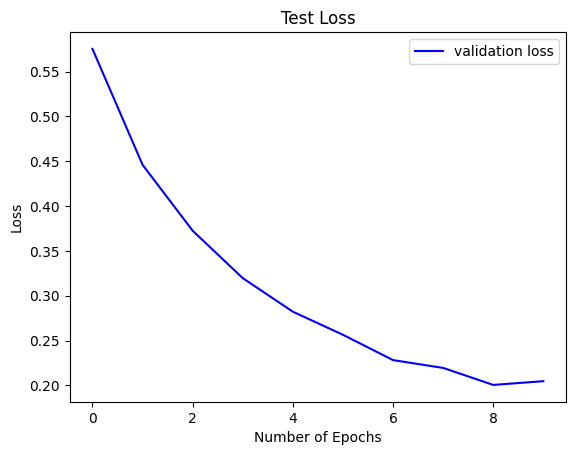

In [146]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [147]:
predictions = model.predict(X_test, batch_size=bs)

18/18 [==============================] - 8s 417ms/step


In [148]:
print(predictions)

[[2.7078746e-03 1.1420362e-01 7.3911116e-04 8.8234943e-01]
 [6.4062729e-04 3.9282064e-03 6.8173156e-04 9.9474949e-01]
 [1.0759204e-02 8.4217161e-02 1.4721270e-02 8.9030236e-01]
 ...
 [7.1253049e-01 1.1617965e-03 2.7914041e-01 7.1672997e-03]
 [5.9799239e-04 3.6237729e-03 1.7857540e-03 9.9399251e-01]
 [2.3495199e-02 1.0413480e-03 2.5284626e-03 9.7293502e-01]]


In [149]:
predictions = np.argmax(predictions, axis=1)

In [150]:
print(predictions)

[3 3 3 1 3 0 0 3 3 0 2 3 3 0 0 0 3 1 3 1 0 3 3 0 3 3 0 0 0 3 0 3 0 0 3 2 3
 3 2 3 0 2 3 3 3 3 3 3 2 0 0 3 0 3 3 3 3 1 3 3 3 0 3 3 3 3 3 1 3 1 0 0 0 2
 1 3 0 3 3 1 0 3 0 3 3 0 3 0 3 2 0 0 3 3 1 3 3 3 3 3 0 3 3 0 3 0 0 2 0 2 3
 3 3 3 3 0 0 3 3 3 3 0 3 3 0 3 0 1 2 3 0 1 2 3 1 1 0 3 0 3 0 0 3 1 0 0 3 0
 3 3 2 0 0 3 0 3 0 3 3 1 3 3 3 0 3 0 1 0 3 0 3 0 2 0 3 0 3 0 0 0 0 0 3 3 0
 3 3 0 3 3 1 3 0 3 3 0 3 0 3 0 3 3 0 3 3 3 3 3 3 3 0 0 3 3 1 3 0 0 0 0 3 3
 0 3 0 3 3 0 0 3 0 3 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 1 0 3 3 2 3 3 0 3 3
 3 0 1 2 3 0 3 0 3 0 1 3 3 0 3 3 0 3 0 0 3 3 3 0 3 0 0 3 0 0 0 3 0 0 0 3 0
 3 3 3 0 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 0 3 2 3 0 3 3 0 3 3 0 3 0 0 3 0
 3 3 1 0 0 3 3 3 0 3 3 0 3 0 0 3 0 0 0 3 3 3 3 2 3 0 3 3 0 3 3 0 0 3 3 3 0
 3 0 3 0 3 3 0 0 3 2 3 0 3 3 0 0 0 0 3 0 3 2 3 3 0 3 0 0 0 3 3 0 0 3 3 0 3
 0 3 3 1 3 3 3 3 1 3 3 3 3 0 0 3 3 3 0 3 3 3 3 0 0 3 3 0 0 3 0 0 3 3 3 3 0
 3 3 3 3 0 0 3 3 3 3 0 2 3 3 0 3 0 2 3 3 3 3 3 0 3 3 3 0 3 3 3 3 0 0 3 3 3
 3 3 1 3 3 3 3 3 3 3 1 3 

In [152]:
y_test_labels = np.argmax(y_test, axis=1)


In [153]:
print(y_test_labels)

[3 3 3 1 3 0 0 3 3 2 2 3 3 0 0 0 3 3 3 1 0 3 3 0 3 3 0 0 0 3 0 3 0 0 3 2 3
 3 0 3 0 2 3 3 3 3 3 3 2 3 0 3 0 3 3 3 3 1 3 3 3 0 3 3 3 3 3 3 3 1 0 0 0 3
 1 3 0 3 3 3 0 3 0 3 0 0 3 0 3 2 0 3 3 3 1 1 3 3 3 3 0 3 3 0 3 3 0 2 0 3 3
 3 3 3 3 0 0 3 0 3 3 0 3 3 0 3 2 1 2 3 0 3 2 3 1 1 0 3 0 3 0 0 3 1 0 0 3 0
 3 3 0 0 0 3 0 3 2 3 3 1 3 3 3 0 3 0 1 0 3 0 3 0 2 0 3 0 3 0 0 0 0 0 3 3 0
 3 3 0 3 3 1 3 0 3 3 0 3 3 3 0 3 0 0 3 3 3 3 3 3 3 0 0 3 3 1 3 0 0 3 0 3 3
 0 3 0 3 3 0 0 3 0 3 3 0 3 3 3 0 3 3 0 3 3 3 0 3 3 3 3 1 0 3 3 2 3 3 0 3 3
 3 2 1 2 3 0 3 0 3 0 1 3 3 0 3 3 0 3 0 2 3 3 3 0 3 0 0 3 0 0 2 3 0 0 0 3 0
 3 1 3 0 3 3 3 2 3 3 0 3 3 3 3 3 1 3 3 3 3 0 3 2 3 0 3 3 0 3 3 0 3 0 3 3 0
 3 3 1 0 0 3 3 3 0 3 3 0 3 0 0 3 0 0 0 3 3 0 3 0 3 0 3 3 0 3 3 0 3 3 3 3 0
 3 0 3 0 3 3 0 0 3 2 3 0 3 3 0 0 0 0 3 0 3 2 3 3 0 3 0 0 0 3 3 0 0 3 3 0 3
 0 3 3 3 3 3 3 3 1 3 3 3 3 0 2 3 3 3 0 3 3 3 3 0 0 3 3 0 0 3 0 0 3 3 3 3 0
 3 3 3 3 0 0 3 3 3 3 0 2 0 3 0 3 0 2 3 3 3 3 0 0 3 3 3 0 3 3 3 3 0 0 3 3 3
 3 3 1 3 3 3 3 3 3 3 1 1 

In [155]:

print(classification_report(
    y_test_labels,
    predictions
))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       184
           1       0.81      0.81      0.81        26
           2       0.75      0.69      0.72        26
           3       0.96      0.96      0.96       326

    accuracy                           0.93       562
   macro avg       0.86      0.85      0.85       562
weighted avg       0.93      0.93      0.93       562

